In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%cd '/content/gdrive/My Drive/SIPaKMeD1'
%pwd

/content/gdrive/.shortcut-targets-by-id/1ezMhY31V1pkC3t3SbNIOD5h4SHrRMyf8/SIPaKMeD1


'/content/gdrive/.shortcut-targets-by-id/1ezMhY31V1pkC3t3SbNIOD5h4SHrRMyf8/SIPaKMeD1'

In [5]:
TRAIN_DIR_PATH = '/content/gdrive/MyDrive/SIPaKMeD1/Train'
TEST_DIR_PATH = '/content/gdrive/MyDrive/SIPaKMeD1/Validation'

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pytorch imports

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F

In [7]:
transformations = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5]) # resnet18
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5]) # resnet18
    ])
}

In [71]:
# hyperparamters

learning_rate = 0.01
batch_size = 4
num_epochs = 30
num_classes = 5

# device
device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(device)

cuda


In [53]:
train_dataset = torchvision.datasets.ImageFolder(TRAIN_DIR_PATH,transform=transformations['train'])
test_dataset = torchvision.datasets.ImageFolder(TEST_DIR_PATH,transform=transformations['test'])

In [54]:
len(train_dataset),len(test_dataset),train_dataset[0][0].shape

(3241, 808, torch.Size([3, 224, 224]))

In [55]:
classes_to_idx = train_dataset.class_to_idx
print(classes_to_idx)

{'Dyskeratotic': 0, 'Koilocytotic': 1, 'Metaplastic': 2, 'Parabasal': 3, 'Superficial Intermediate': 4}


In [72]:
# dataloaders
train_loader = DataLoader(dataset=train_dataset,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=4)

test_loader = DataLoader(dataset=test_dataset,
                       batch_size=1,
                       shuffle=False,
                       num_workers=4)

In [73]:
# testing dataloading 

examples = iter(train_loader)
samples,labels = examples.next()
print(samples.shape,labels.shape) # batch_size=4

len(train_loader),len(test_loader)

torch.Size([4, 3, 224, 224]) torch.Size([4])


(811, 808)

In [58]:
# custom CNN model class

class ConvNet(nn.Module):
    def __init__(self,model,num_classes):
        super(ConvNet,self).__init__()
        self.base_model = nn.Sequential(*list(model.children())[:-1]) # model excluding last FC layer
        self.linear1 = nn.Linear(in_features=512,out_features=120)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(in_features=120,out_features=num_classes)
    
    def forward(self,x):
        x = self.base_model(x)
        x = torch.flatten(x,1)
        lin = self.linear1(x)
        x = self.relu(lin)
        out = self.linear2(x)
        return lin, out

In [59]:
# model,loss,optimizer

model = torchvision.models.resnet18(pretrained=True) # base model

model = ConvNet(model,num_classes)

model = model.to(device) 

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [ ]:
print(model)

In [ ]:
# training loop

n_iters = len(train_loader)

for epoch in range(num_epochs):
    model.train()
    for ii,(images,labels) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)
        
        _,outputs = model(images)
        loss = criterion(outputs,labels)
                
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if (ii+1)%800 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{ii+1}/{n_iters}], Loss = {loss.item():.6f}')
            
    print('-----------------------------------------------------------')

In [45]:
# save model 
MODEL_PATH = 'model_v3.pth'
torch.save(model.state_dict(),MODEL_PATH)

In [75]:
def eval_model_extract_features(model,features,dataloader,phase):
    
    with torch.no_grad():
       
        # for entire test set
        n_correct = 0
        n_samples = 0

        # for each class label
        n_class_correct = [0 for i in range(num_classes)]
        n_class_samples = [0 for i in range(num_classes)]

        for images,labels in dataloader:

            images = images.to(device)
            labels = labels.to(device)

            ftrs,outputs = model(images)
            features.append(ftrs)

            _,preds = torch.max(outputs,1)
            n_samples += labels.size(0)
            n_correct += (preds == labels).sum().item()
                
        accuracy = n_correct/float(n_samples)

        print(f'Accuracy of model on {phase} dataset = {(100.0 * accuracy):.4f} %')

    return features

In [ ]:
features = []

# train set features

train_loader = DataLoader(dataset=train_dataset,batch_size=1,
                         shuffle=True,num_workers=4)

features = eval_model_extract_features(model=model,
                                       features=features,
                                       dataloader=train_loader,
                                       phase='training')

print(len(features))

In [ ]:
# test set features

features = eval_model_extract_features(model=model,
                                       features=features,
                                       dataloader=test_loader,
                                       phase='testing')

print(len(features))

In [ ]:
len(features)

In [64]:
ftrs = features.copy()

In [65]:
for i in range(len(ftrs)):
    ftrs[i] = ftrs[i].cpu().numpy()

type(ftrs),ftrs[0].dtype,ftrs[0][0].dtype

(list, dtype('float32'), dtype('float32'))

In [68]:
ftrs = np.array(ftrs)
ftrs.shape

(4049, 1, 120)

In [69]:
n_samples = ftrs.shape[0]*ftrs.shape[1]
n_features = ftrs.shape[2]
ftrs = ftrs.reshape(n_samples,n_features)
print(ftrs.shape)

(4049, 120)


In [70]:
# save to csv
ftrs_df = pd.DataFrame(ftrs)
ftrs_df.to_csv('fc_layer_features.csv',index=False)

# reloading the saved csv into a df

ftrs_df = pd.read_csv('fc_layer_features.csv')
ftrs_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119
0,-1.806504,-0.386489,-7.536183,-0.210516,5.752031,-2.274142,-0.222461,-0.893873,-0.295816,-9.903834,-0.260706,-1.680031,-1.329431,-0.308857,-0.276741,-1.174525,-0.431168,-0.351364,-0.345054,-0.487349,-0.619755,-4.217516,-0.266173,-6.412664,-0.453090,-0.301903,-0.268712,-0.278184,-0.252111,-0.221647,-1.776069,-0.821031,-3.594498,-1.084858,-0.341453,-0.187056,-2.033834,-0.269655,-1.832667,-0.262006,...,-0.314502,-1.023082,-0.245265,-0.270651,-0.175869,-0.311283,-0.307659,-1.461883,-0.439180,-0.316227,-0.624020,-0.207118,-0.347644,-0.295988,-0.731774,-0.227975,-1.937126,-0.239043,-0.340237,-0.415482,-1.590821,-0.391584,-0.324736,-0.423150,-0.895092,-2.020070,-0.393635,-0.234435,-1.274096,-0.410841,-0.294763,-0.327568,-0.277368,-0.354308,-0.290333,-1.223474,-1.154992,-0.243300,-0.857846,-1.235451
1,-1.123188,-0.300514,-3.250547,-0.179335,0.006173,-1.620017,-0.094740,-0.781820,-0.215494,-8.772902,-0.202664,-1.329963,-0.822074,-0.194117,-0.229315,-0.812129,-0.229095,-0.247020,-0.231253,-0.419273,-0.495208,2.176816,-0.178190,-2.053672,-0.388312,-0.203186,-0.213364,-0.165592,-0.197274,-0.140413,-1.222979,-0.470002,-2.263047,-0.729439,-0.209357,-0.129463,-1.687592,-0.251246,-1.411895,-0.271647,...,-0.212878,-0.832950,-0.142639,-0.184978,-0.114366,-0.216275,-0.194898,-1.081541,-0.309360,-2.046867,-0.482567,-0.180039,-0.246712,-0.186322,-0.551037,-0.148867,-0.856468,-0.172360,-0.233619,-0.316639,-1.037652,-0.313215,-0.195739,-0.326669,-0.512929,-1.337196,-0.268251,-0.159651,-0.818104,-0.285854,-0.219104,-0.215397,-0.176864,-0.247087,-0.191484,-0.727832,-1.077451,-0.185157,-0.657431,-0.778795
2,-2.987532,-0.613923,9.266627,-0.450706,-10.058759,-2.173989,-0.467522,-1.310740,-0.568006,-9.994783,-0.452027,-1.666863,-1.138544,-0.451966,-0.470602,-1.059525,-0.515353,-0.534744,-0.521506,-0.709960,-0.683288,-13.039850,-0.396853,-0.776362,-0.551639,-0.539320,-0.592505,-0.537633,-0.348302,-0.446003,-2.374409,-0.996177,-4.730834,-1.127719,-0.656816,-0.181198,-2.518395,-0.445504,-2.640681,-0.284621,...,-0.591614,-1.944661,-0.289930,-0.282948,-0.385096,-0.353444,-0.395175,-1.628440,-0.564278,-7.189322,-0.638939,-0.272712,-0.514279,-0.350691,-1.126527,-0.513865,-2.144697,-0.144224,-0.508413,-0.588035,-2.829966,-0.564189,-0.453655,-0.791950,-0.784842,-4.288143,-0.572846,-0.540732,-1.119214,-0.521043,-0.458755,-0.538123,-0.462538,-0.492227,-0.546340,-1.114654,-1.636545,-0.347108,-1.373149,-2.217204
3,-1.531339,-0.363607,-0.305410,-0.183459,-4.460710,-1.810109,-0.264748,-0.818558,-0.316849,-4.586951,-0.220484,-1.449237,-0.966867,-0.278177,-0.259577,-0.830874,-0.491084,-0.290542,-0.304236,-0.423766,-0.556755,-5.843710,-0.203366,3.366841,-0.386863,-0.284186,-0.294928,-0.292443,-0.238962,-0.229705,-1.416039,-0.583035,-2.854762,-0.811228,-0.281104,-0.097431,-1.691842,-0.343735,-1.648874,-0.305839,...,-0.303419,-1.031986,-0.181141,-0.183607,-0.150238,-0.221050,-0.255845,-1.305273,-0.331069,-0.731056,-0.486627,-0.154125,-0.278536,-0.206400,-0.607327,-0.294297,-1.311876,-0.127037,-0.281817,-0.363205,-1.535330,-0.374030,-0.235143,-0.414162,-0.677399,-1.857800,-0.348466,-0.294041,-1.056659,-0.340561,-0.279008,-0.390414,-0.214394,-0.275932,-0.276222,-0.898256,-1.252755,-0.251640,-0.778869,-1.282782
4,-1.799630,-0.406341,-9.129948,-0.205440,0.296389,-1.871519,-0.296464,-0.879378,-0.362367,7.701873,-0.296798,-1.796010,-1.358931,-0.375618,-0.308461,-0.991195,-0.531288,-0.352802,-0.392206,-0.474664,-0.648552,1.766087,-0.276587,1.074623,-0.393828,-0.395824,-0.284061,-0.358957,-0.308215,-0.348313,-1.458485,-0.714466,-4.032472,-1.115667,-0.219721,-0.122488,-1.861076,-0.352635,-1.990987,-0.378446,...,-0.384406,-0.881133,-0.252325,-0.264962,-0.178443,-0.278407,-0.373900,-1.413245,-0.443549,-4.073105,-0.614456,-0.224797,-0

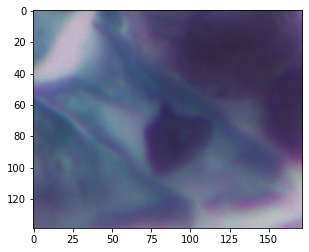

In [32]:
from PIL import Image

img = Image.open('/content/gdrive/MyDrive/SIPaKMeD1/Train/Koilocytotic/007_03.bmp')

plt.imshow(img)